In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import yfinance as yf  
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

import get_data as gd
from portfolio import *

In [12]:
tics = ['DUST','NUGT',
                'LABD','LABU',
                'YINN','YANG',
                'EDZ','EDC']

In [13]:
data,ticks=gd.get_data(tics)
pi=data.drop(columns='SPY')
pi=pi.drop(columns='Date') 

spy=data['SPY']
spy=spy.diff()/spy[1:]

pval = 10_000
closes = pi.T.values

[*********************100%***********************]  1 of 1 completed
querrying DUST ...
[*********************100%***********************]  1 of 1 completed
querrying NUGT ...
[*********************100%***********************]  1 of 1 completed
querrying LABD ...
[*********************100%***********************]  1 of 1 completed
querrying LABU ...
[*********************100%***********************]  1 of 1 completed
querrying YINN ...
[*********************100%***********************]  1 of 1 completed
querrying YANG ...
[*********************100%***********************]  1 of 1 completed
querrying EDZ ...
[*********************100%***********************]  1 of 1 completed
querrying EDC ...
[*********************100%***********************]  1 of 1 completed


## Monte Carlo for weights

In [18]:
weights,sharpes,rp,cov=MonteCarlo(10000,pi)
opt_weights=weights[np.argmax(sharpes)]
sharpe,rp,vol,ret=getSharpe(pi, opt_weights)

In [19]:
print(sharpe)
print(vol)

7.282736986951784
0.03341090452524457


In [20]:
port_w = opt_weights
port_shares = -(pval*port_w)/closes.T[0,:]

In [21]:
out = dict()
for i in range(opt_weights.shape[0]):
    key = list(pi.columns)[i]
    out[key] = opt_weights[i]

Text(0.5, 1.0, '')

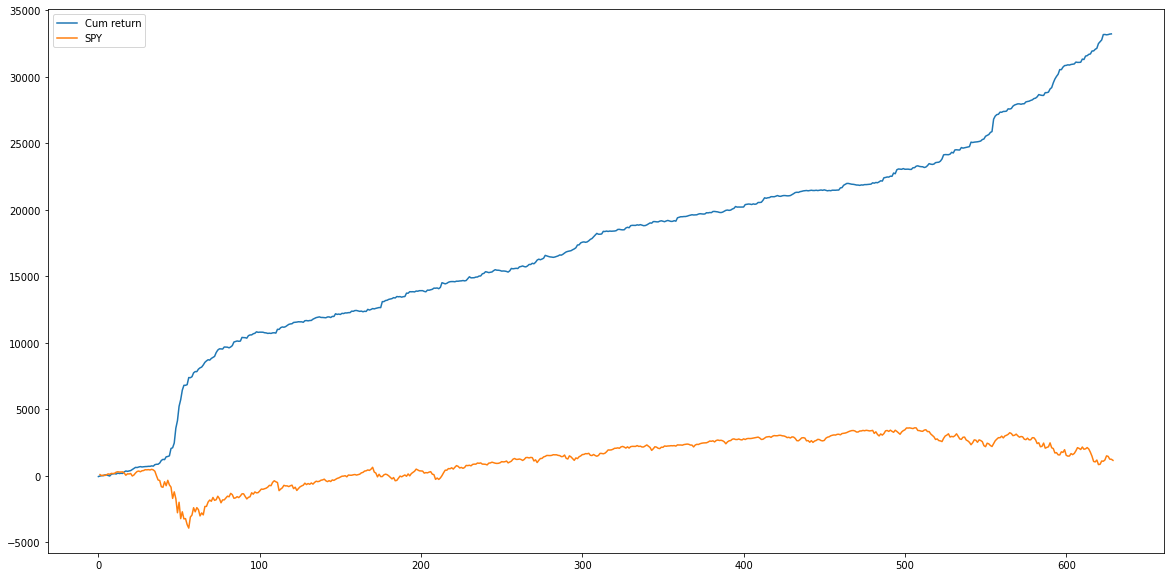

In [22]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(np.cumsum(ret)*pval,label='Cum return')
plt.plot(np.cumsum(spy)*pval,label='SPY')
plt.legend()
plt.title('')   

In [23]:
def rebalance_criteria(closes, pval, port_w, threshold=0.20):
    
    nbr_rebalances = 0
    weights_t = np.zeros((pi.shape))
    shares_t = np.zeros((pi.shape))
    portolio_value_t = np.zeros((pi.shape[0]))
    portolio_value_t[0] = pval

    for i in range(pi.shape[0]):

        if i==0:

            weights_t[0,:] = port_w
            shares_t[0,:] = -(portolio_value_t[0]*port_w)/closes.T[0,:]

        else:
            temp_share_t = shares_t[i-1,:]
            temp_portofolio_t = portolio_value_t[i-1]
            temp_weight_t = -(closes.T[i,:]*temp_share_t)/(closes.T[i,:]@temp_share_t)
            
            #Rebalance (change the index in temp_weight_t and the second index in weights_t to choose which asset is used in this criteria
            if np.abs(temp_weight_t[2] - weights_t[0,2])/np.abs(weights_t[0,2])>threshold:
#                 print(temp_weight_t)
#             if np.sum(np.abs(temp_weight_t-weights_t[0,:])/np.abs(weights_t[0,:])>threhold)>0:
                weights_t[i,:] = port_w
                portolio_value_t[i] = closes.T[i,:]@temp_share_t
                shares_t[i,:] = -(portolio_value_t[i]*port_w)/closes.T[i,:]
                nbr_rebalances+=1
                
            #No Rebalance
            else:
                shares_t[i,:] = temp_share_t
                portolio_value_t[i] = closes.T[i,:]@temp_share_t
                weights_t[i,:] = -(closes.T[i,:]*temp_share_t)/portolio_value_t[i]
                
    return weights_t, shares_t, portolio_value_t,nbr_rebalances

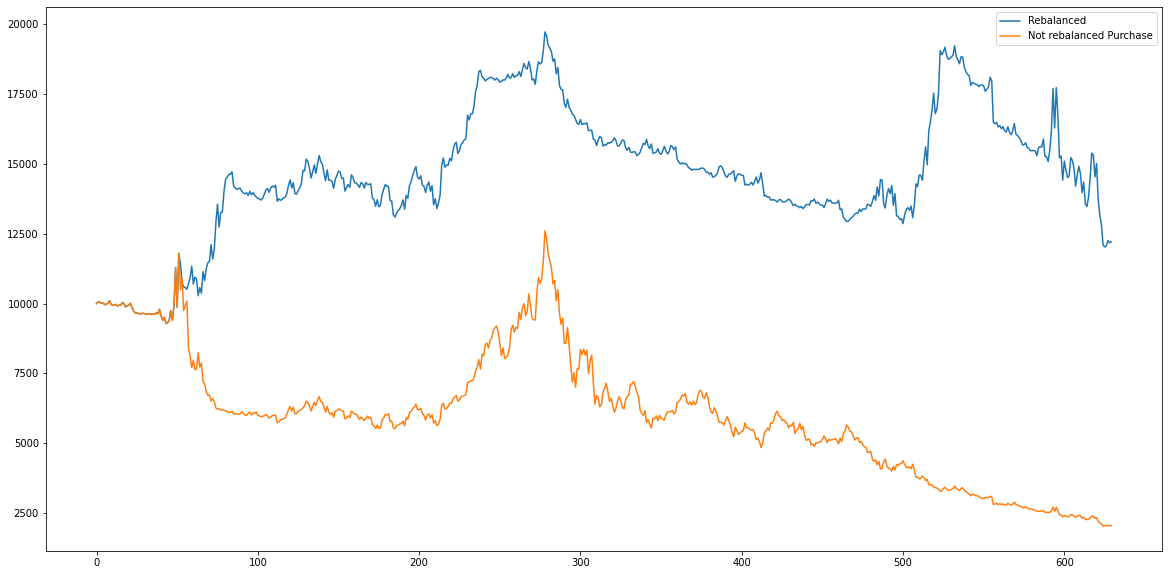

In [24]:
weights_t, shares_t, portolio_value_t, nbr_rebalances = rebalance_criteria(closes, pval, port_w, threshold=0.81)
plt.plot(portolio_value_t)
plt.plot(np.dot(port_shares, closes))
plt.legend(['Rebalanced','Not rebalanced Purchase'])

In [25]:
def get_stats(closes, weights):
    sharpe_ratios = []
    volatilities = []
    returns = []
    for i in range(weights.shape[0]):
        sharpe,rp,port_var,rets = getSharpe(pd.DataFrame(closes.T), weights[i,:])
        sharpe_ratios.append(sharpe)
        volatilities.append(port_var)
        returns.append(rets)
    return sharpe_ratios, volatilities, returns


sharpe_ratios, volatilities, returns = get_stats(closes, weights_t)

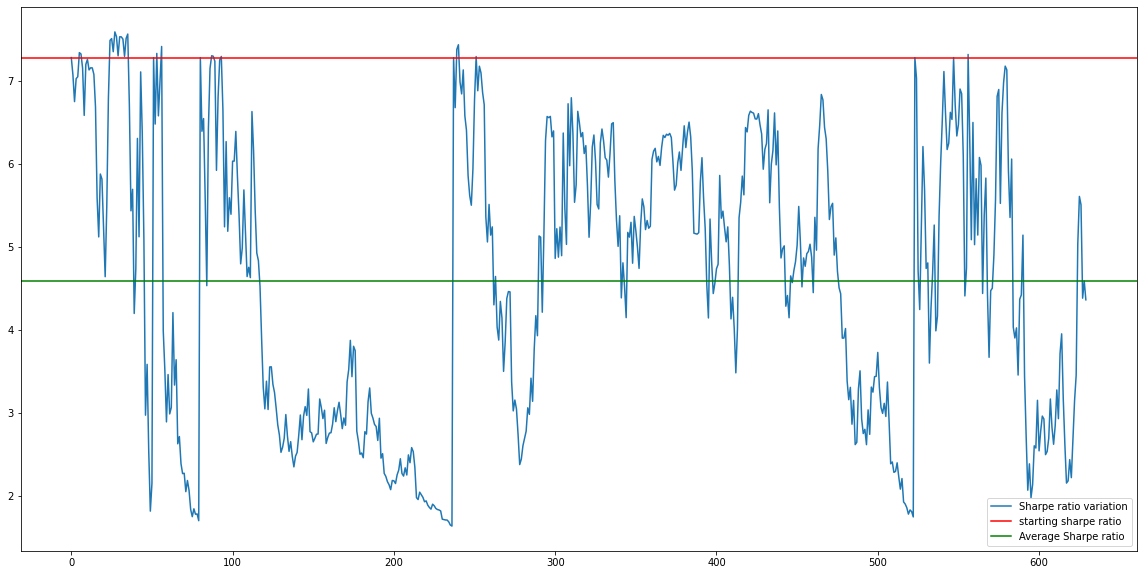

In [26]:
plt.plot(sharpe_ratios)
plt.axhline(y=sharpe_ratios[0], color='r', linestyle='-')
plt.axhline(y=np.mean(sharpe_ratios), color='g', linestyle='-')
plt.legend(['Sharpe ratio variation','starting sharpe ratio', 'Average Sharpe ratio'])

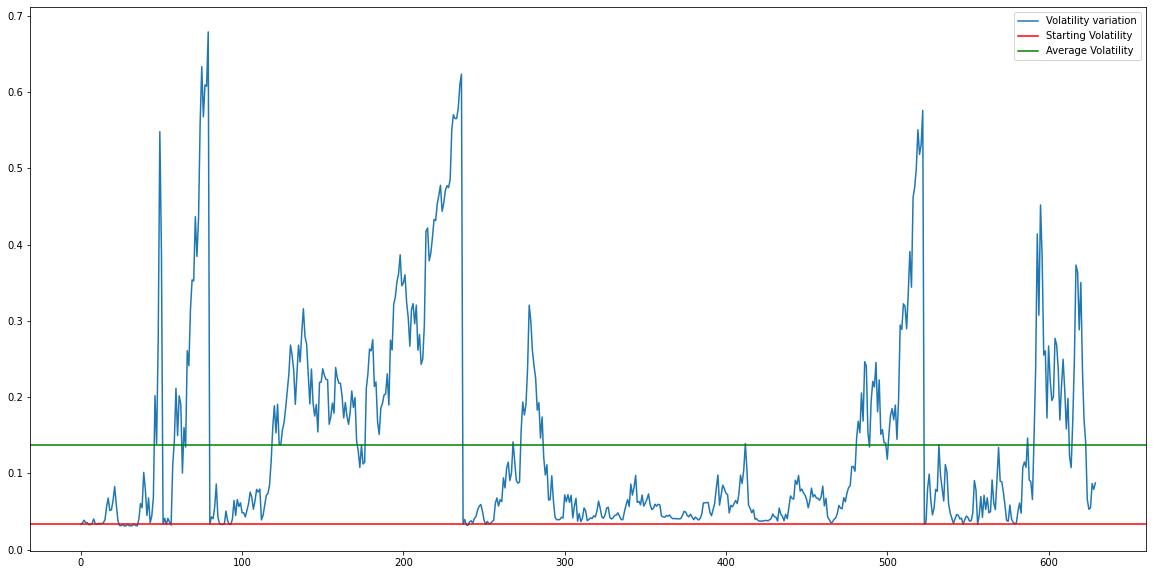

In [27]:
plt.plot(volatilities)
plt.axhline(y=volatilities[0], color='r', linestyle='-')
plt.axhline(y=np.mean(volatilities), color='g', linestyle='-')
plt.legend(['Volatility variation','Starting Volatility', 'Average Volatility'])

In [28]:
def find_info_thresholds(closes, pval, port_w, thresholds=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]):
    all_results = dict()
    for threshold in thresholds:
        weights_t, shares_t, portolio_value_t, nbr_rebalances = rebalance_criteria(closes, pval, port_w, threshold)
        sharpe_ratios, volatilities, returns = get_stats(closes, weights_t)
        cum_return = (portolio_value_t[-1]/portolio_value_t[0]-1)
        dict_resutls = {"weights":weights_t,"shares":shares_t,
                        "portolio_value":portolio_value_t,"nbr_rebalances":nbr_rebalances,
                        "sharpe_ratios":sharpe_ratios,"volatilities":volatilities, "cum_return":cum_return,
                        "mean_sharpe_ratio":np.mean(sharpe_ratios),
                        "max_sharpe_ratio":np.max(sharpe_ratios),
                        "min_sharpe_ratio":np.min(sharpe_ratios),
                        "mean_volatility":np.mean(volatilities),
                        "max_volatility":np.max(volatilities),
                        "min_volatility":np.min(volatilities)}
                        
        all_results[threshold] = dict_resutls
    return all_results

def plot_threhold_balanced_not_rebalanced(closes, results, threshold):
    portfolio_value_t = results[threshold]['portolio_value']
    port_shares = results[threshold]['shares']
    plt.plot(portfolio_value_t)
    plt.plot(np.dot(port_shares[0], closes))
    plt.legend(['Rebalanced','Not rebalanced Purchase'])
    

def plot_sharpe_ratio_per_threhold(results, threshold):
    sharpe_ratios = results[threshold]['sharpe_ratios']
    plt.plot(sharpe_ratios)
    plt.axhline(y=sharpe_ratios[0], color='r', linestyle='-')
    plt.axhline(y=np.mean(sharpe_ratios), color='g', linestyle='-')
    plt.legend(['Sharpe ratio variation','Not rebalanced sharpe ratio', 'Average Sharpe ratio'])
    
def plot_volatility_per_threhold(results, threshold):
    volatilities = results[threshold]['volatilities']
    plt.plot(volatilities)
    plt.axhline(y=volatilities[0], color='r', linestyle='-')
    plt.axhline(y=np.mean(volatilities), color='g', linestyle='-')
    plt.legend(['Volatility variation','Not rebalanced Volatility', 'Average Volatility'])

In [29]:
thresholds = [0,0.1,0.2,0.3,0.42,0.5,0.6,0.7,0.8,0.9,1]
results = find_info_thresholds(closes, pval, port_w, thresholds=thresholds)

In [30]:
means_sharpe_ratios = [results[key]['mean_sharpe_ratio'] for key in results.keys()]
means_volatilities = [results[key]['mean_volatility'] for key in results.keys()]
cum_returns = [results[key]['cum_return'] for key in results.keys()]

In [31]:
for threshold in thresholds:
    print("Threhold value: ", threshold)
    print("Mean Sharpe Ratio: ", results[threshold]['mean_sharpe_ratio'])
    print("Mean Volatility: ", results[threshold]['mean_volatility'])
    print("Cum return: ",  results[threshold]['cum_return'])
    print('-'*50)

Threhold value:  0
Mean Sharpe Ratio:  7.282736986951784
Mean Volatility:  0.03341090452524457
Cum return:  -0.1468836984130144
--------------------------------------------------
Threhold value:  0.1
Mean Sharpe Ratio:  7.085802990677485
Mean Volatility:  0.03548958793484599
Cum return:  -0.25664433241947626
--------------------------------------------------
Threhold value:  0.2
Mean Sharpe Ratio:  6.67081475571288
Mean Volatility:  0.04085535599779641
Cum return:  -0.39438581412545126
--------------------------------------------------
Threhold value:  0.3
Mean Sharpe Ratio:  5.982255683869031
Mean Volatility:  0.055333860262588824
Cum return:  -0.33384616572936754
--------------------------------------------------
Threhold value:  0.42
Mean Sharpe Ratio:  5.60354417317683
Mean Volatility:  0.06819869168947607
Cum return:  -0.38383063374128834
--------------------------------------------------
Threhold value:  0.5
Mean Sharpe Ratio:  5.214945161515139
Mean Volatility:  0.08020948264762

<AxesSubplot:xlabel='Date'>

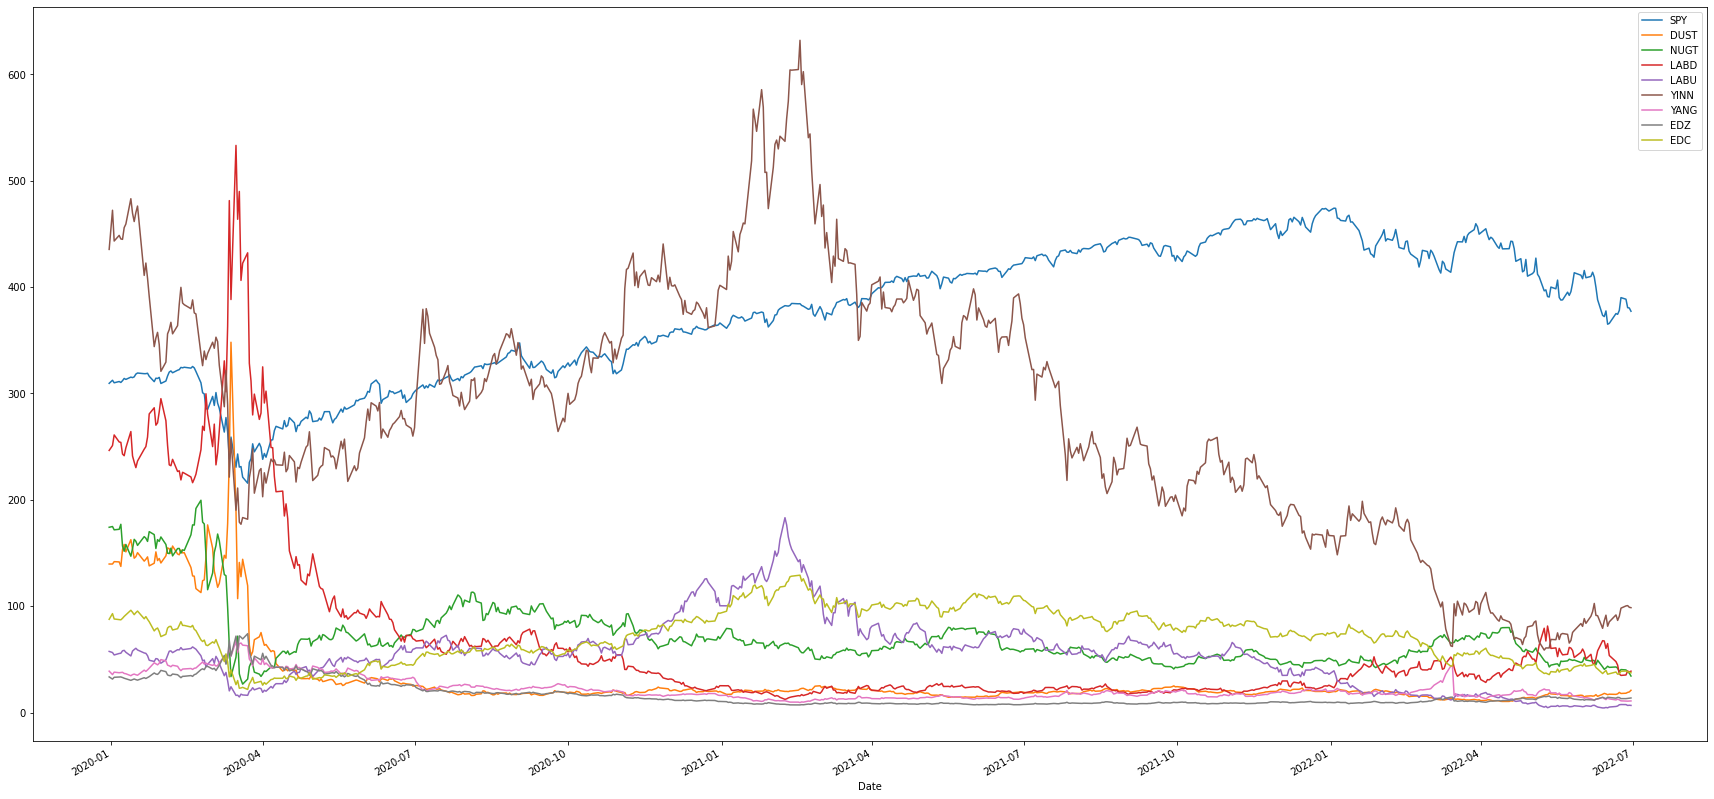

In [32]:
plt.rcParams["figure.figsize"] = (30,15)
data.plot(x="Date", y=data.columns[1:])

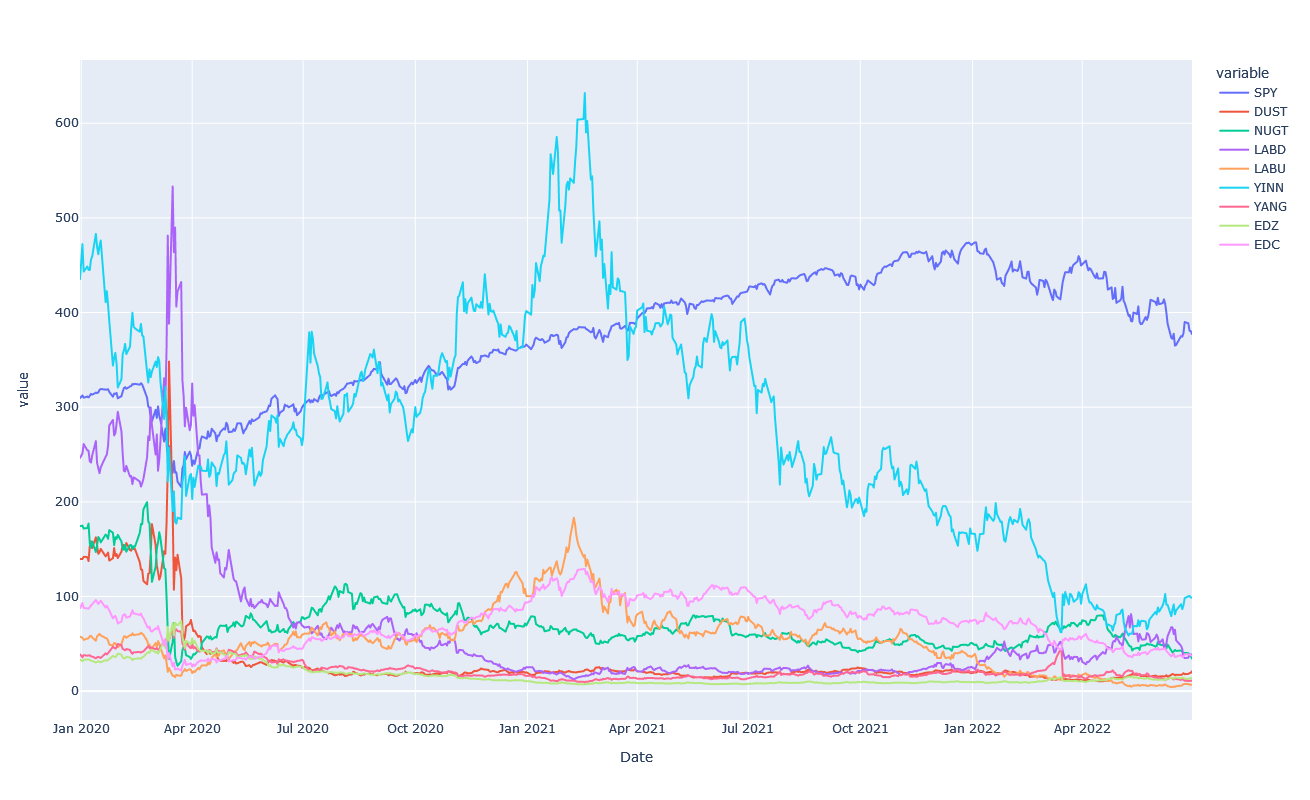

In [33]:
# same graph as the previous but interactive, if you don't have plotly installed just ignore it
import plotly.express as px
from plotly.offline import iplot

fig = px.line(data, x='Date', y=data.columns[1:])
fig.update_layout(
    autosize=False,
    width=1500,
    height=800,)
fig.show()

In [34]:
def calculate_sharpe_var(pi, asset):
    returns= pi[asset].diff()/pi[asset]
    returns=returns.to_numpy()[1:]
    cov = np.cov(returns.T)

    rp = (returns.mean(0)*252)
    rets = (returns)*1 

    port_var = cov*252 
    sharpe = -rp/np.sqrt(port_var)
    return port_var, sharpe

<BarContainer object of 8 artists>

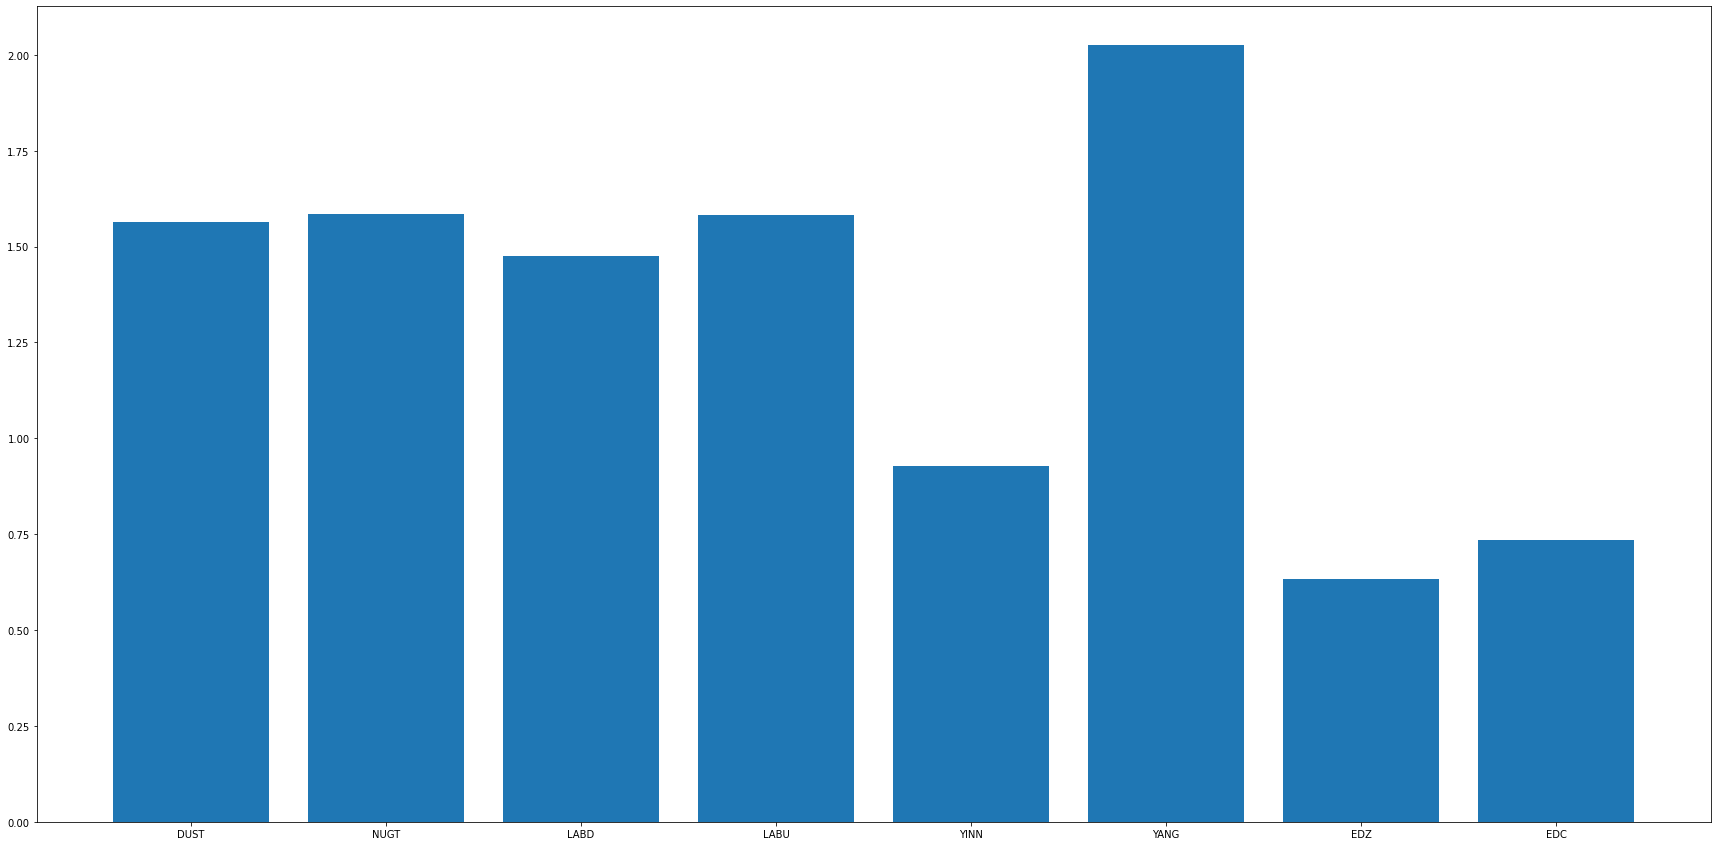

In [35]:
sharpes_assets = dict()
volatilities_assests = dict()
for asset in list(pi.columns):
    sharpes_assets[asset], volatilities_assests[asset] = calculate_sharpe_var(pi, asset)
plt.bar(range(len(sharpes_assets)), sharpes_assets.values(), tick_label=list(sharpes_assets.keys()))

<BarContainer object of 8 artists>

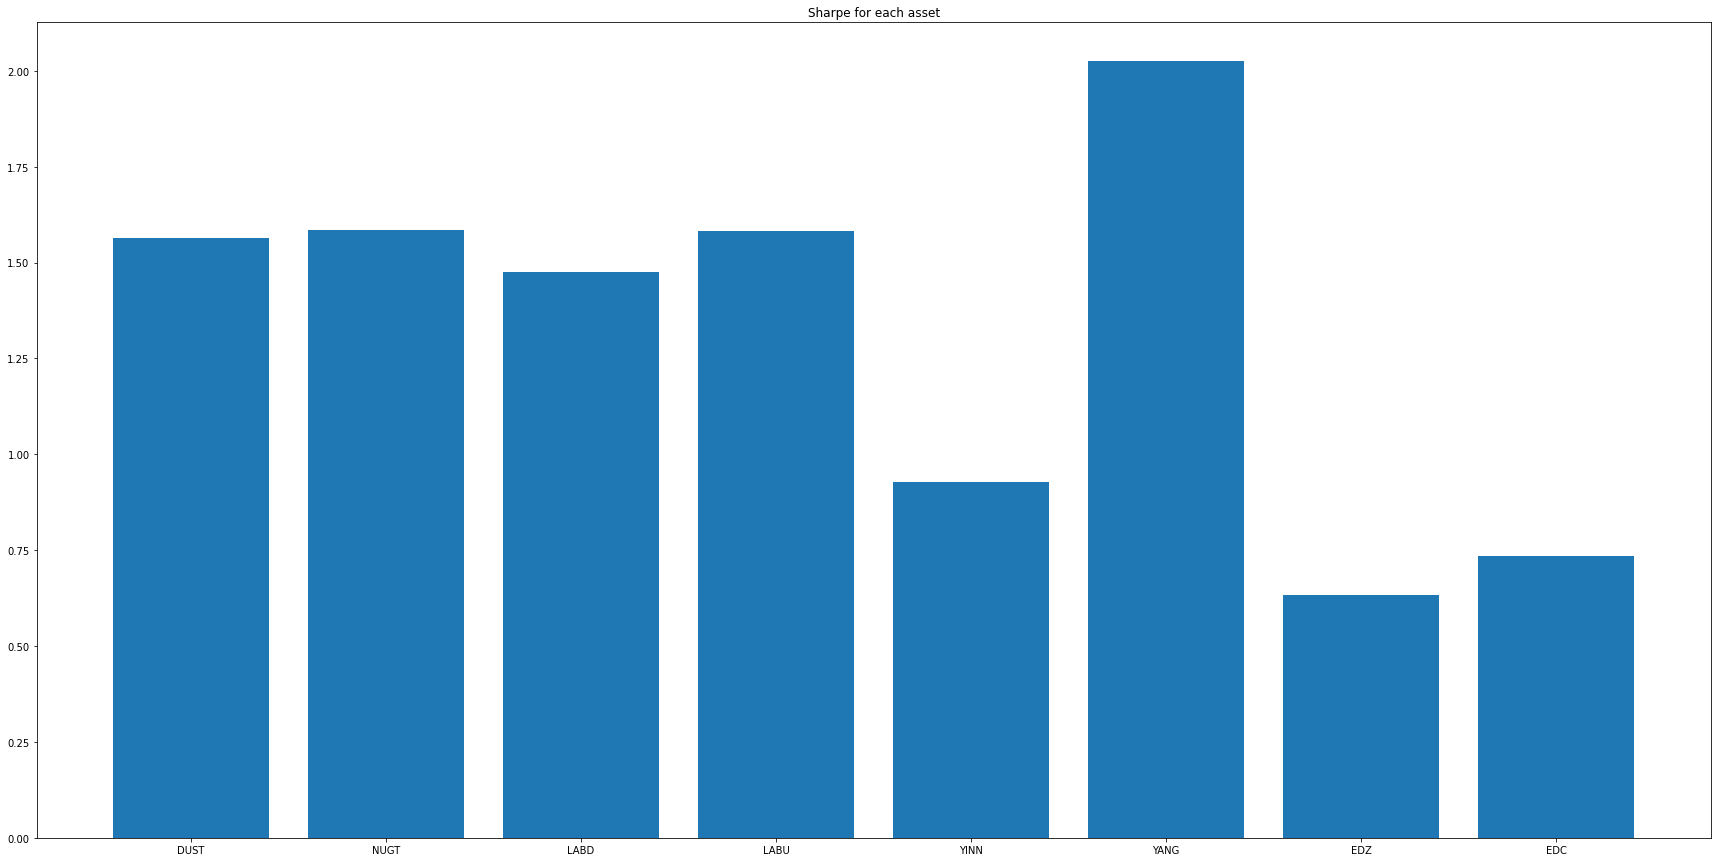

In [36]:
plt.title('Sharpe for each asset')
plt.bar(range(len(sharpes_assets)), sharpes_assets.values(), tick_label=list(sharpes_assets.keys()))

<BarContainer object of 8 artists>

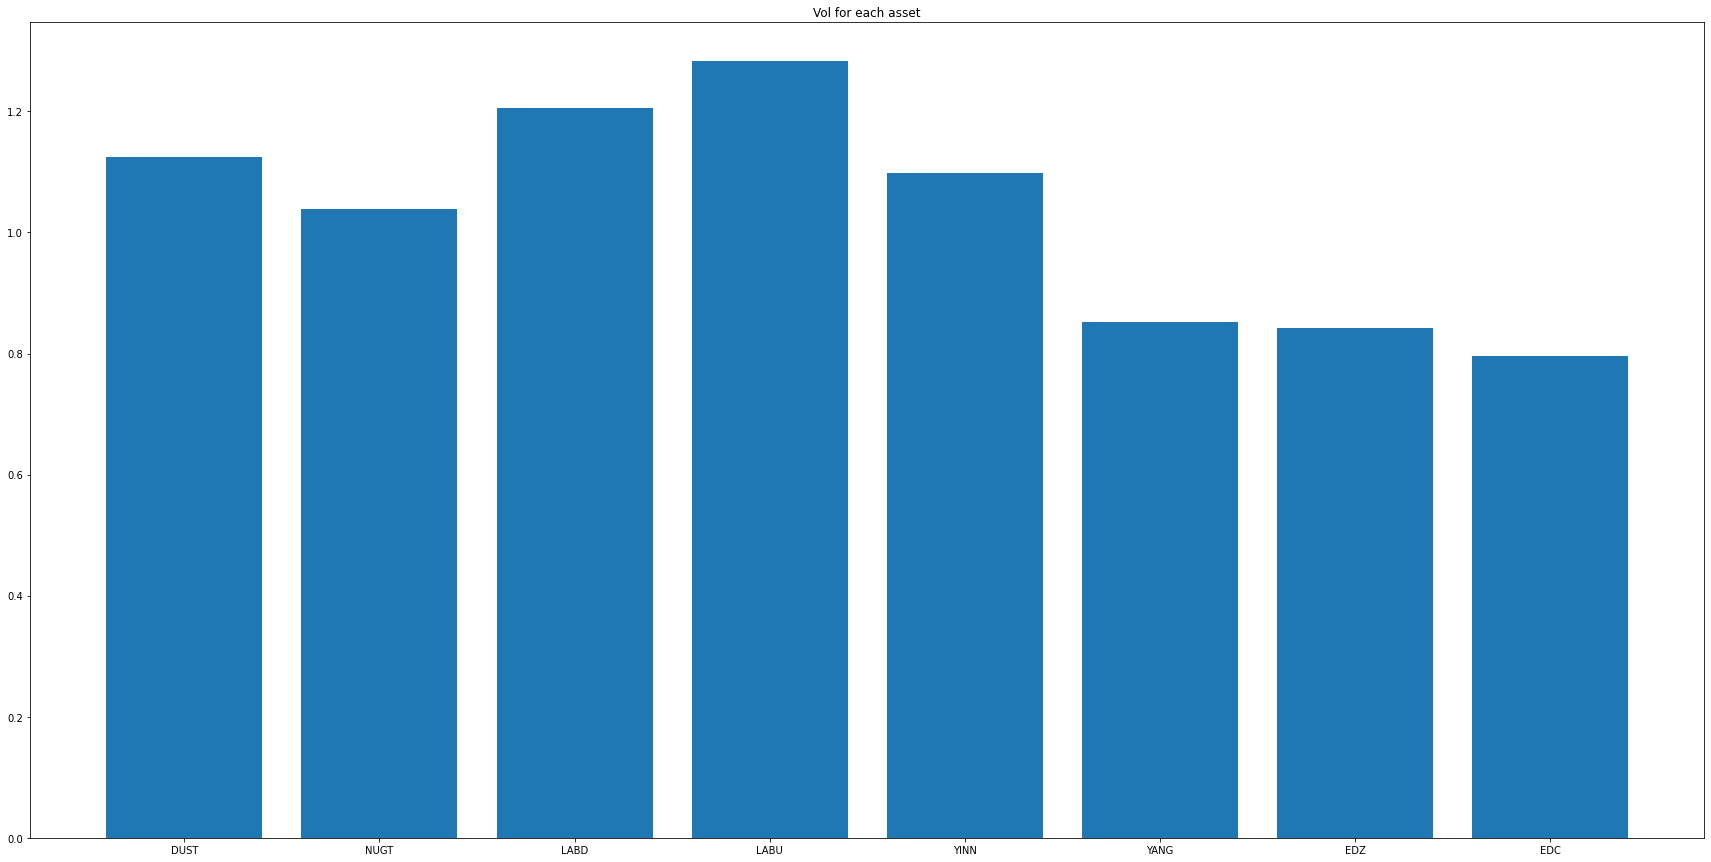

In [37]:
plt.title('Vol for each asset')
plt.bar(range(len(volatilities_assests)), volatilities_assests.values(), tick_label=list(volatilities_assests.keys()))

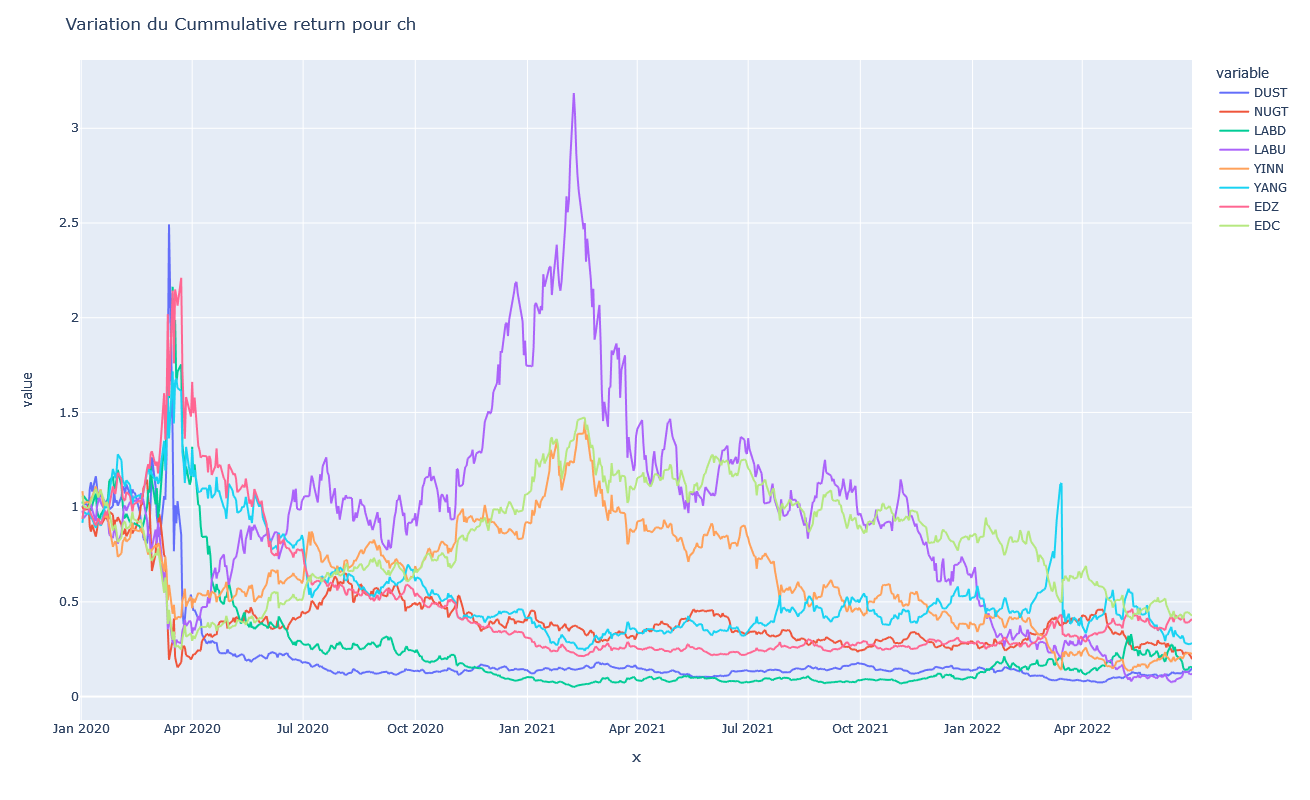

In [38]:
import plotly.express as px
from plotly.offline import iplot



fig = px.line((1+pi.pct_change()).cumprod(), x=data.Date, y=pi.columns)
fig.update_layout(
    autosize=False,
    width=1500,
    height=800,title="Variation du Cummulative return pour ch")
fig.show()